In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time

@torch.jit.script
def parallel_metropolis_update(state: torch.Tensor, W: torch.Tensor, temperature: float, steps: int):
    """Parallel Metropolis update.
    - ΔE = 2 * s_i * h_i  (energy *increase* when spin i is flipped)
    - Always flip if ΔE ≤ 0 (energy‑lowering)
    - Otherwise flip with exp(‑ΔE / T)  (ΔE > 0)
    """
    for _ in range(steps):
        h = torch.matmul(W, state)                     # local fields
        delta_E =  2.0 * state * h                     # *** correct sign ***

        # deterministic flips that LOWER the energy
        flip_mask = delta_E <= 0

        # stochastic flips that RAISE the energy
        rand_vals = torch.rand(state.size(0), device=state.device)
        prob = torch.exp(-delta_E / temperature)       # valid only where ΔE > 0
        flip_mask |= (rand_vals < prob) & (delta_E > 0)

        state = state.clone()
        state[flip_mask] *= -1
    return state

class HopfieldNetwork:
    def __init__(self, N: int, temperature: float = 1.0, device: str | None = None):
        self.device = torch.device(device) if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.N           = N
        self.temperature = temperature
        self.memories    = []          # list[Tensor]
        self.M           = 0
        # *** weights are initialised to zero and will be ⟨ξ ξᵀ⟩/N ***
        self.W = torch.zeros((N, N), dtype=torch.float32, device=self.device)

    # ------------------------------------------------------------------
    #  memory management
    # ------------------------------------------------------------------
    def add_memory(self, memory: torch.Tensor):
        """Store a pattern and update weights with Hebb rule normalised by 1/N."""
        memory = memory.to(self.device)
        assert memory.shape == (self.N,)
        assert torch.all((memory == 1) | (memory == -1)), "Memory must be ±1"
        self.memories.append(memory)
        self.M = len(self.memories)
        #self.W += torch.ger(memory, memory) / self.N
        #self.W.fill_diagonal_(0)
        self.learn_memories()

    def store_random_memories(self, M: int):
        rand_mem = (torch.randint(0, 2, (self.N,M), device=self.device) * 2 - 1).float()
        for m in range(M):
            self.memories.append(rand_mem[:,m])
        self.M = len(self.memories)
        self.learn_memories()

    def learn_memories(self):
        mem_matrix = torch.stack(self.memories)
        self.W = (mem_matrix.t() @ mem_matrix) / self.N
        self.W.fill_diagonal_(0)

    def store_checkerboard_memory(self):
        pattern = torch.tensor([(1 if i % 2 == 0 else -1) for i in range(self.N)], dtype=torch.float32, device=self.device)
        self.add_memory(pattern)

    # ------------------------------------------------------------------
    #  dynamics
    # ------------------------------------------------------------------
    def retrieve(self, initial_state: torch.Tensor, steps: int = 10):
        state = initial_state.clone().float().to(self.device)
        return parallel_metropolis_update(state, self.W, self.temperature, steps)

    # ------------------------------------------------------------------
    #  analysis helpers
    # ------------------------------------------------------------------
    def compute_overlaps(self, state: torch.Tensor):
        mem_matrix = torch.stack(self.memories)                   # (M, N)
        overlaps   = ((mem_matrix @ state) / self.N).abs()             # sign‑invariant
        return overlaps

    def get_alpha(self):
        return self.M / self.N

    # ------------------------------------------------------------------
    #  phase‑diagram routine (unchanged except for more steps default)
    # ------------------------------------------------------------------
    def phase_diagram(self, alphas, temperatures, steps=100, runs_per_setting=20, noise=0.50 ):
        results = torch.zeros((len(alphas), len(temperatures)),device=self.device)
        for i, alpha in enumerate(alphas):
            M = int(alpha * self.N)
            for j, T in enumerate(temperatures):
                time_start = time.time()

                overlaps = torch.zeros((runs_per_setting,M), device=self.device)
                #print(f"alpha={alpha}, T={T}")
                with torch.no_grad():
                    for r in range(runs_per_setting):
                        net = HopfieldNetwork(self.N, temperature=T, device=self.device)
                        net.store_random_memories(M)
                        true_memory = net.memories[torch.randint(0, M, (1,), device=self.device)].squeeze(0)
                        noisy = true_memory.clone()
                        flip_mask = torch.rand(self.N, device=self.device) < noise
                        noisy[flip_mask] *= -1
                        final_state = net.retrieve(noisy, steps=steps)
                        overlaps[r,:] = net.compute_overlaps(final_state)
                avg_overlap = overlaps.max(1)[0].mean().item()

                results[i, j] = avg_overlap
                time_passed = (time.time()-time_start)/runs_per_setting
                print(f"alpha={alpha:1.2f}, T={T:1.2f}, overlap={results[i, j]:1.2f} +/- { overlaps.max(1)[0].std().item():1.2f}, time: {time_passed}")
        return results.cpu().numpy()
        # plotting
def plot_phase_diagram( alphas, temperatures, results):
  plt.figure(figsize=(8, 6))
  plt.imshow(results.T, origin="lower", aspect="auto",
              extent=( alphas[0], alphas[-1], temperatures[0], temperatures[-1]),
              cmap="viridis", vmin=0., vmax=1.)
  plt.colorbar(label="Average |overlap|")
  plt.ylabel("Temperature T")
  plt.xlabel(r"α = M / N")
  plt.title("Hopfield phase diagram (Metropolis (sync.))")
  plt.show()


# ----------------------------------------------------------------------
#  quick test
# ----------------------------------------------------------------------
if __name__ == "__main__":
    N = 5000
    M = 10
    T = 0.5     # intentionally > T_c
    print(f"N={N}, M={M}, T={T}, alpha={M/N}")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Testing on", device)
    net = HopfieldNetwork(N, T, device)
    net.store_random_memories(M)
    true_memory = net.memories[3]

    # 10 % noise
    noisy = true_memory.clone()
    noisy[torch.rand(N, device=device) < 0.5] *= -1
    retrieved = net.retrieve(noisy, steps=100)
    print("overlap (50 % noise):", (retrieved @ true_memory).abs().item() / N)

    # 90 % noise
    noisy2 = true_memory.clone()
    noisy2[torch.rand(N, device=device) < 0.80] *= -1
    retrieved2 = net.retrieve(noisy2, steps=100)
    print("overlap (20 % noise):", (retrieved2 @ true_memory).abs().item() / N)

    # Uncomment to run phase diagram
    alphas = np.linspace(0.01, 0.20, 12)
    temperatures = np.linspace(0.01, 1.5, 10)
    results = net.phase_diagram(alphas, temperatures,steps=200,runs_per_setting=100,noise=0.2)


N=5000, M=10, T=0.5, alpha=0.002
Testing on cuda
overlap (50 % noise): 0.03
overlap (20 % noise): 0.9576
alpha=0.01, T=0.01, overlap=1.00 +/- 0.00, time: 0.1063032841682434
alpha=0.01, T=0.18, overlap=1.00 +/- 0.00, time: 0.10731702327728271
alpha=0.01, T=0.34, overlap=0.99 +/- 0.00, time: 0.11050443172454834
alpha=0.01, T=0.51, overlap=0.95 +/- 0.00, time: 0.10930917263031006
alpha=0.01, T=0.67, overlap=0.83 +/- 0.01, time: 0.10989331722259521
alpha=0.01, T=0.84, overlap=0.25 +/- 0.09, time: 0.11101483583450317
alpha=0.01, T=1.00, overlap=0.16 +/- 0.02, time: 0.11059869527816772
alpha=0.01, T=1.17, overlap=0.00 +/- 0.00, time: 0.11105909824371338
alpha=0.01, T=1.33, overlap=0.00 +/- 0.00, time: 0.11060466051101685
alpha=0.01, T=1.50, overlap=0.00 +/- 0.00, time: 0.11078166723251343
alpha=0.03, T=0.01, overlap=1.00 +/- 0.00, time: 0.10769079208374023
alpha=0.03, T=0.18, overlap=1.00 +/- 0.00, time: 0.10953956842422485
alpha=0.03, T=0.34, overlap=0.99 +/- 0.00, time: 0.11401581525802612

In [ ]:
torch.rand((2,10)).max(1)[0].mean()

tensor(0.8719)

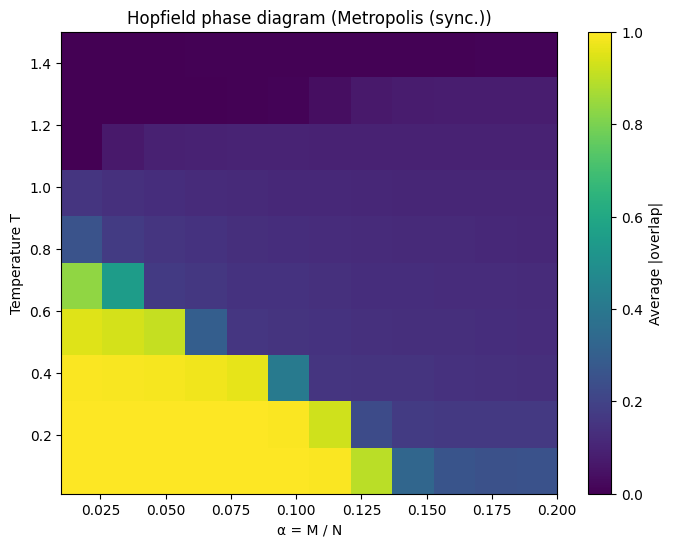

In [ ]:

plot_phase_diagram( alphas, temperatures, results)